In [1]:
# Import Libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *
%matplotlib inline

## Load Datasets from CSV Files

In [2]:
# Read CSV files containing sales transactions and temperatures
pathfile = './datasets/'
data_years = ['2018', '2019', '2020', '2021']


# Load datasets with sales between 2014 and 2019
filename = 'y_'
df_sales = pd.read_csv(pathfile + filename + '2017.csv', infer_datetime_format = True, encoding = 'latin-1')
print('Initiall Shape df_sales: {}, year: 2017'.format(df_sales.shape) )

for year in data_years:
    df = pd.read_csv(pathfile + filename + year + '.csv', infer_datetime_format = True, encoding = 'latin-1')
    df_sales = pd.concat([df_sales, df], ignore_index=True)
    print('Shapes df: {}, df_sales: {}, year: {}'.format(df.shape, df_sales.shape, year) )

# Read dataset with Minimum Phoenix Temperatures
df_min_temp = pd.read_csv(pathfile + 'phx_min_temp.csv', sep='\t', encoding = 'utf-8')

# Read dataset with Maximum Phoenix Temperatures
df_max_temp = pd.read_csv(pathfile + 'phx_max_temp.csv', sep='\t', encoding = 'utf-8')

df_tmp = None

Initiall Shape df_sales: (25030, 11), year: 2017
Shapes df: (27331, 11), df_sales: (52361, 11), year: 2018
Shapes df: (27993, 11), df_sales: (80354, 11), year: 2019
Shapes df: (26658, 11), df_sales: (107012, 11), year: 2020
Shapes df: (9495, 11), df_sales: (116507, 11), year: 2021


In [3]:
df_sales.head()

,Unnamed: 0,Type,Date,Num,Memo,Name,Item,Qty,Sales Price,Amount,Balance
0,Inventory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00-Beer & Spirits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"00177USA - R2 Casino Azul Blanc (Casino Azul, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Invoice,01/18/2017,70229,"Casino Azul, Tequila Blanco",Total Wine 1006,00-Beer & Spirits:00177USA - R2 Casino Azul Bl...,6.0,29.95,179.7,179.7
4,NaN,Invoice,01/18/2017,70233,"Casino Azul, Tequila Blanco",Total Wine 1004,00-Beer & Spirits:00177USA - R2 Casino Azul Bl...,6.0,29.95,179.7,359.4


## Data Preprocessing

In [4]:
# Dictionary with interesting Products for the project
target_items = {'60190':'Dipinti, Pinot Grigio La Vis',
                '20209':'Alverdi, Pinot Grigio',
                '70165':'Santome, Prosecco Extra Dry',
                '50215':'Carpineto, Dogajolo Rosso',
                '70208':'Italo Cescon, Pinot Grigio',
                '70271':'Le Contesse, Pinot Noir Rose Brut'
               }
df_sales = clean_sales(df_sales, list(target_items.keys()))
df_sales.head()

Final Dataset Shape: (8048, 5)


,quantity,price,item_code,month,year
5623,7.0,6.99,20209,1,2017
5624,12.0,6.99,20209,1,2017
5625,12.0,6.99,20209,1,2017
5626,12.0,6.99,20209,1,2017
5627,6.0,6.99,20209,1,2017


Check for NaN's Values

In [5]:
print('Null values:\n{}'.format(df_sales.isnull().sum())) # Display Null values per Column
print(df_sales[df_sales['price'].isnull()]) # Display rows with Null values

Null values:
quantity     0
price        1
item_code    0
month        0
year         0
dtype: int64
        quantity  price item_code  month  year
100379       2.0    NaN     70271      5  2020


Imputate average price for 1 row with Nan value

In [6]:
df_sales.loc[100379,'price'] = df_sales.price[df_sales['item_code']=='70271'].mean()
print('Null values:\n{}'.format(df_sales.isnull().sum())) # Display Null values per Column

Null values:
quantity     0
price        0
item_code    0
month        0
year         0
dtype: int64


Create Time Series for each product by Month

In [7]:
df = df_sales.groupby(by=['item_code','year','month'], as_index=False).agg(
    quantity=('quantity','sum'), 
    avg_price=('price', np.mean)
) # Group by item, month and year to result in a time series for each product
df['day'] = "01"
df['date'] = pd.to_datetime(df[['year','month','day']]) # Create a date column using year, month and day
df.drop(['month','day','year'], axis=1, inplace=True) # Drop day, month and year columns
df.head()

,item_code,quantity,avg_price,date
0,20209,109.0,6.990000,2017-01-01
1,20209,136.0,7.144666,2017-02-01
2,20209,129.0,6.990000,2017-03-01
3,20209,190.0,6.990000,2017-04-01
4,20209,172.0,6.990000,2017-05-01


Check the number of Data Points per Item

In [8]:
for item, values in target_items.items():
    print('Item: {}, Data Points:{}, {}'.format(item, df.date[df['item_code']==item].count(), values))

Item: 60190, Data Points:37, Dipinti, Pinot Grigio La Vis
Item: 20209, Data Points:52, Alverdi, Pinot Grigio
Item: 70165, Data Points:52, Santome, Prosecco Extra Dry
Item: 50215, Data Points:52, Carpineto, Dogajolo Rosso
Item: 70208, Data Points:52, Italo Cescon, Pinot Grigio
Item: 70271, Data Points:43, Le Contesse, Pinot Noir Rose Brut


In [9]:
# Remove rows with date ='2021-04-01' since April 2021 data is incomplete
df.drop(df[df['date'] == '2021-04-01'].index, axis=0, inplace = True)
df.shape

(282, 4)

## Additional Features

The next section adds 2 new features to dataset:
- Phoenix Minimum Temperatures
- Phoenix Maximum Temperatures

In [10]:
# Perform cleanning and formatting to temperature datasets
df_min_temp_transformed = extract_temperature(df_min_temp, new_colum_name='min_temp')
df_max_temp_transformed = extract_temperature(df_max_temp, new_colum_name='max_temp')
print('Shapes: Min Temp: {}, Max Temp:{}'.format(df_min_temp_transformed.shape, df_max_temp_transformed.shape))

Shapes: Min Temp: (84, 2), Max Temp:(84, 2)


In [11]:
# Perform a inner join between transformed temperatures datasets
df_transformed = pd.merge(df_min_temp_transformed,
                          df_max_temp_transformed,
                          how='inner',
                          on='date'                          
                         )
print(f'Shape: {df_transformed.shape}')

Shape: (84, 3)


In [12]:
df = pd.merge(df,
              df_transformed,
              how='inner',
              on='date'
             )
print(f'Shape: {df.shape}')

Shape: (282, 6)


In [13]:
# Filter datapoint to be used
# Here I'm looking for the most recent 36 observations

num_data_point = 36
df = df[df['date']>='2018-04-01']
print(f'Shape: {df.shape}')
print(f'Expected Shape:{(len(target_items)*num_data_point)}')

Shape: (216, 6)
Expected Shape:216


In [14]:
# Print number of observations by Product

for item, values in target_items.items():
    print('Item: {}, Data Points:{}, {}'.format(item, df.date[df['item_code']==item].count(), values))

Item: 60190, Data Points:36, Dipinti, Pinot Grigio La Vis
Item: 20209, Data Points:36, Alverdi, Pinot Grigio
Item: 70165, Data Points:36, Santome, Prosecco Extra Dry
Item: 50215, Data Points:36, Carpineto, Dogajolo Rosso
Item: 70208, Data Points:36, Italo Cescon, Pinot Grigio
Item: 70271, Data Points:36, Le Contesse, Pinot Noir Rose Brut


## Final dataset

Feature Description:

"item_code": Code reference uses to identify the product</br>
"quantity": Indicate the number of bottle sold for the corresponding month</br>
"avg_price": Average price of the product for the indicated month</br>
"date": Monthly date to denotate time series sequence</br>
"min_temp": Reflect the minimum temperatures measured in Phoenix Arizona during the month</br>
"max_temp": Reflect the maximum temperatures measured in Phoenix Arizona during the month</br>

In [15]:
df.head()

,item_code,quantity,avg_price,date,min_temp,max_temp
66,20209,629.0,7.151200,2018-04-01,54,100
67,50215,472.0,10.253250,2018-04-01,54,100
68,60190,12.0,8.990000,2018-04-01,54,100
69,70165,447.0,9.694074,2018-04-01,54,100
70,70208,237.0,11.578235,2018-04-01,54,100


## Visualization by Product

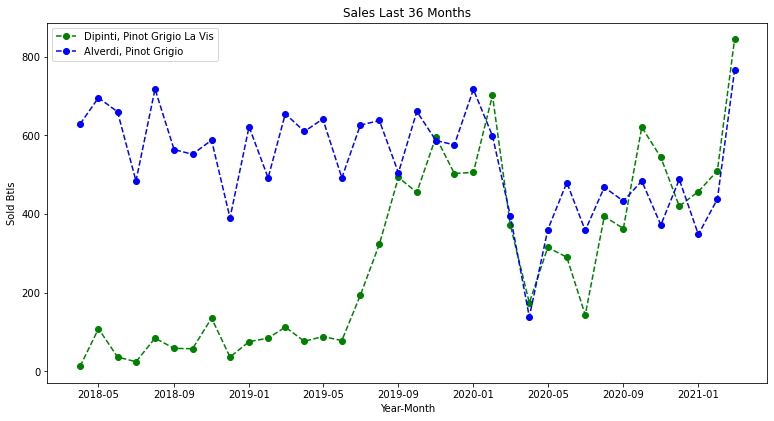

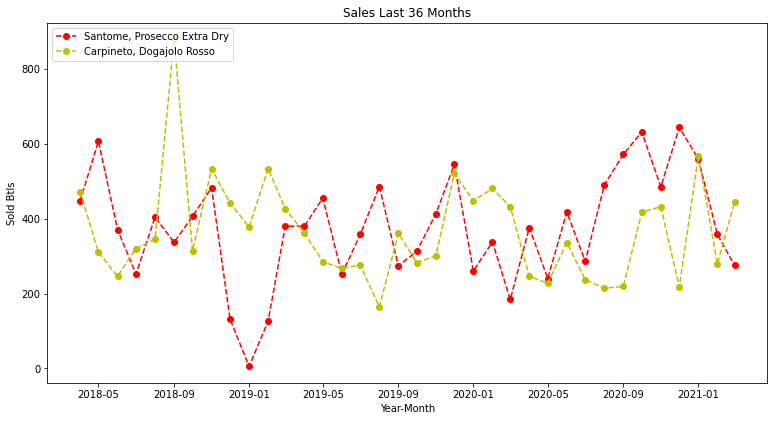

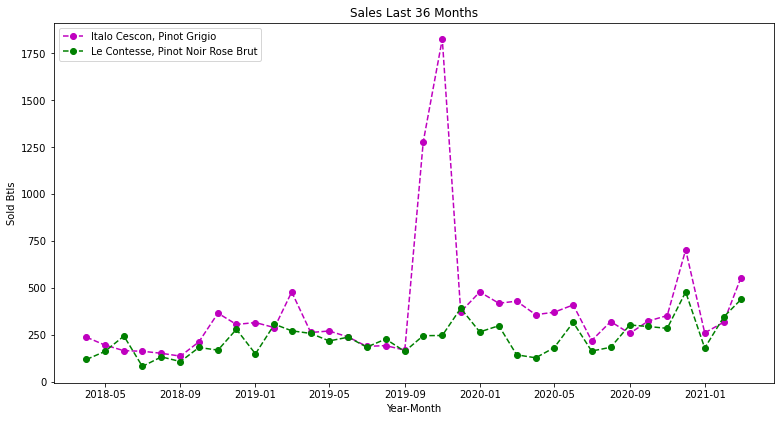

In [16]:
# Create 
plot_item(df, list(target_items.keys())[0:2], list(target_items.values())[0:2], ['go--','bo--'] )
plot_item(df, list(target_items.keys())[2:4], list(target_items.values())[2:4], ['ro--','yo--'] )
plot_item(df, list(target_items.keys())[4:6], list(target_items.values())[4:6], ['mo--','go--'] )

In [ ]:
# df_sales.set_index('date', inplace=True) # Set 'date' as index

In [ ]:
# Subset data points to be used for each time series
# For this project, I will be using 36 observations for training and 3 for testing

training_filter = (df['date']>='2018-01-01')
test_filter = (df['date']>='2021-01-01')